In [2]:
import pandas as pd 
import psycopg2
import getpass
from sklearn.impute import KNNImputer
from helpers import *
import warnings
warnings.filterwarnings("ignore")

In [3]:
def print_proportions(df):
    """
    # Print the total proportions!

    input: pandas df
    
    """
    rows, vars = df.shape
    print('')
    for l, vals in df.iteritems():
        if str(l[1]) == 'mean':
            ratio = 1.0 * vals.dropna().count() / rows
            print(str(l) + ': ' + str(round(ratio, 3)*100) + '% present')

    return None 



## Mortality cohort

In [4]:
demographics = pd.read_hdf('data_icu.h5', key='demographics') 

In [5]:
# include patients only on the 1st icu stay, older than 18 and with a length of stay from 1 to 10 days 
print("Number of patients hospitalized: ", len(set((demographics.subject_id))))
print("Number of patients with in hospital mortality: ", demographics.mort_hosp.value_counts())
print("Number of patients with in icu mortality: ", demographics.mort_icu.value_counts())

Number of patients hospitalized:  34651
Number of patients with in hospital mortality:  0    31309
1     3342
Name: mort_hosp, dtype: int64
Number of patients with in icu mortality:  0    32354
1     2297
Name: mort_icu, dtype: int64


In [6]:
demographics.hadm_id.value_counts().sort_values()

145834    1
194540    1
112213    1
143045    1
194023    1
         ..
129380    1
136391    1
108939    1
185654    1
113369    1
Name: hadm_id, Length: 34651, dtype: int64

In [7]:
subject_id_set = set(demographics['subject_id'])
hadm_id_set = set(demographics['hadm_id'])
icustay_id_set = set(demographics['icustay_id'])

## Labs and vitals 

In [8]:
var_map = get_variable_mapping("resources\itemid_to_variable_map.csv")
var_map

,LEVEL2,LEVEL1,LINKSTO
itemid,,,
50861,Alanine aminotransferase,Alanine aminotransferase,labevents
769,Alanine aminotransferase,Alanine aminotransferase,chartevents
220644,Alanine aminotransferase,Alanine aminotransferase,chartevents
50862,Albumin,Albumin,labevents
772,Albumin,Albumin,chartevents
...,...,...,...
40473,Urine output,Urine output,outputevents
40715,Urine output,Urine output,outputevents
43175,Urine output,Urine output,outputevents


In [9]:
var_map[var_map.index == '50963']

,LEVEL2,LEVEL1,LINKSTO
itemid,,,


In [10]:
chartitems_to_keep = set(var_map.loc[var_map['LINKSTO'] == 'chartevents'].index)
#chartitems_to_keep = set([ str(i) for i in chartitems_to_keep ])

labitems_to_keep = set(var_map.loc[var_map['LINKSTO'] == 'labevents'].index)



In [11]:
labs_vitals = pd.read_hdf('data_icu.h5', key='labs_vitals', start=0, stop=1000000) 

In [12]:
#labs_vitals_o

In [13]:
#labs_vitals = labs_vitals_o[:1000000]

In [14]:
#### hourly buckets ####################################
to_hours = lambda x: max(0, x.days*24 + x.seconds // 3600)

#  the value is str, convert to numeric
labs_vitals['value'] = pd.to_numeric(labs_vitals['value'], 'coerce')

# join and add in labs_vital the icu intime and outime, to separate in hourly buckets
demographics = demographics.set_index("icustay_id")
labs_vitals = labs_vitals.set_index('icustay_id').join(demographics[['intime', 'outtime']])

# to hourly buckets
labs_vitals['hours_in'] = (labs_vitals['charttime'] - labs_vitals['intime']).apply(to_hours)

In [15]:
labs_vitals.hours_in.min()

0

In [16]:
labs_vitals

,subject_id,hadm_id,charttime,itemid,value,valueuom,intime,outtime,hours_in
icustay_id,,,,,,,,,
200028,41710,181955,2133-10-31 13:00:00,220621,279.0,None,2133-10-29 17:13:50,2133-11-01 14:55:14,43
200028,41710,181955,2133-10-31 14:00:00,220277,96.0,%,2133-10-29 17:13:50,2133-11-01 14:55:14,44
200028,41710,181955,2133-10-31 15:00:00,220277,98.0,%,2133-10-29 17:13:50,2133-11-01 14:55:14,45
200028,41710,181955,2133-10-31 16:00:00,220277,99.0,%,2133-10-29 17:13:50,2133-11-01 14:55:14,46
200028,41710,181955,2133-10-31 16:00:00,223761,100.1,?F,2133-10-29 17:13:50,2133-11-01 14:55:14,46
...,...,...,...,...,...,...,...,...,...
299999,7630,129161,2117-09-01 01:50:00,1532,2.4,None,2117-08-31 09:33:11,2117-09-01 16:42:00,16
299999,7630,129161,2117-09-01 01:50:00,1536,139.0,None,2117-08-31 09:33:11,2117-09-01 16:42:00,16
299999,7630,129161,2117-09-01 01:50:00,1542,20.7,None,2117-08-31 09:33:11,2117-09-01 16:42:00,16


In [17]:
#labs_vitals = labs_vitals.sort_values(by=['subject_id', 'charttime'])

# to filter the itemids table
itemids = set(labs_vitals.itemid.astype(str))


connection = psycopg2.connect(
    user = 'postgres',
    database="mimic",
    password=getpass.getpass("Enter postgres password"), 
    host="127.0.0.1", 
    port = "5433",
    options=f'-c search_path=mimiciii')




query_d_items = \
"""
SELECT itemid, label, dbsource, linksto, category, unitname
FROM d_items
WHERE itemid in ({itemids})
;
""".format(itemids=','.join(itemids))
items_ids = pd.read_sql_query(query_d_items, connection).set_index('itemid')


labs_vitals.drop(columns=['charttime', 'intime', 'outtime'], inplace=True)
labs_vitals.set_index('itemid', append=True, inplace=True)

#standardize_units(X, name_col='LEVEL1', inplace=True)
#### Apply variable limits - outliers
#X = apply_variable_limits(X, var_ranges, 'LEVEL2')

In [18]:
labs_vitals = labs_vitals.join(var_map).join(items_ids).set_index(['label', 'LEVEL2'], append=True)
labs_vitals

subject_id  \
icustay_id itemid label                       LEVEL2                               
200028     220621 Glucose (serum)             Glucose                      41710   
           220277 O2 saturation pulseoxymetry Oxygen saturation            41710   
                                              Oxygen saturation            41710   
                                              Oxygen saturation            41710   
           223761 Temperature Fahrenheit      Temperature                  41710   
...                                                                          ...   
299999     1532   Magnesium                   Magnesium                     7630   
           1536   Sodium                      Sodium                        7630   
           1542   WBC                         White blood cell count        7630   
           1529   Glucose                     Glucose                       7630   
           1535   Potassium                   Potassium                     7630   

                                                                      hadm_id  \
icustay_id itemid label                       LEVEL2                            
200028     220621 Glucose (serum)             Glucose                  181955   
           220277 O2 saturation pulseoxymetry Oxygen saturation        181955   
                                              Oxygen saturation        181955   
                                              Oxygen saturation        181955   
           223761 Temperature Fahrenheit      Temperature              181955   
...                                                                       ...   
299999     1532   Magnesium                   Magnesium                129161   
           1536   Sodium                      Sodium                   129161   
           1542   WBC                         White blood cell count   129161   
           1529   Glucose                     Glucose                  129161   
           1535   Potassium                   Potassium                129161   

                                                                      value  \
icustay_id itemid label                       LEVEL2                          
200028     220621 Glucose (serum)             Glucose                 279.0   
           220277 O2 saturation pulseoxymetry Oxygen saturation        96.0   
                                              Oxygen saturation        98.0   
                                              Oxygen saturation        99.0   
           223761 Temperature Fahrenheit      Temperature             100.1   
...                                                                     ...   
299999     1532   Magnesium                   Magnesium                 2.4   
           1536   Sodium                      Sodium                  139.0   
           1542   WBC                         White blood cell count   20.7   
           1529   Glucose                     Glucose                 159.0   
           1535   Potassium                   Potassium                 4.3   

                                                                     valueuom  \
icustay_id itemid label                       LEVEL2                            
200028     220621 Glucose (serum)             Glucose                    None   
           220277 O2 saturation pulseoxymetry Oxygen saturation             %   
                                              Oxygen saturation             %   
                                              Oxygen saturation             %   
           223761 Temperature Fahrenheit      Temperature                  ?F   
...                                                                       ...   
299999     1532   Magnesium                   Magnesium                  None   
           1536   Sodium                      Sodium                     None   
           1542   WBC                         White blood cell count     None   
    

In [19]:
#### aggregate same item_ids according to the extract_mimic_paper





#standardize_units(labs_vitals, name_col='LEVEL2', inplace=True)



# get the names of the aggregated labs and vitals
labs_vitals_names = list(labs_vitals.index.get_level_values('LEVEL2'))
labs_vitals_stats = labs_vitals.groupby(['subject_id', 'hadm_id', 'icustay_id'] + ['LEVEL2'] + ['hours_in']).agg(['mean', 'std', 'count'])

labs_vitals = labs_vitals.groupby(['subject_id', 'hadm_id', 'icustay_id'] + ['LEVEL2'] + ['hours_in']).agg(['mean'])

labs_vitals.columns = labs_vitals.columns.droplevel(0)
labs_vitals.columns.names = ['Aggregated']

demographics['max_hours'] = (demographics['outtime'] - demographics['intime']).apply(to_hours)



# Pivot table droups NaN columns so you lose any uniformly NaN.
labs_vitals = labs_vitals.unstack(level = ['LEVEL2'])
labs_vitals.columns = labs_vitals.columns.reorder_levels(order=['LEVEL2'] + ['Aggregated'])
labs_vitals = labs_vitals.sort_index(axis=0).sort_index(axis=1)


In [20]:
#print("Before droping nan", np.sum(np.isnan(labs_vitals), axis=0)/labs_vitals.shape[0])
np.sum(np.isnan(labs_vitals), axis=0)/labs_vitals.shape[0]

LEVEL2                                Aggregated
Alanine aminotransferase              mean          0.988459
Albumin                               mean          0.993269
Asparate aminotransferase             mean          0.988477
Bilirubin                             mean          0.990911
CO2 (ETCO2, PCO2, etc.)               mean          0.998821
Calcium                               mean          0.960319
Chloride                              mean          0.895926
Cholesterol                           mean          0.998154
Creatinine                            mean          0.896928
Fibrinogen                            mean          0.994564
Fraction inspired oxygen              mean          0.945122
Glucose                               mean          0.856938
Hematocrit                            mean          0.934335
Lactic acid                           mean          0.982169
Magnesium                             mean          0.899484
Oxygen saturation                   

In [21]:
labs_vitals.head()

LEVEL2                                 Alanine aminotransferase Albumin  \
Aggregated                                                 mean    mean   
subject_id hadm_id icustay_id hours_in                                    
3          145834  211552     0                             NaN     NaN   
                              2                             NaN     NaN   
                              3                             NaN     NaN   
                              4                             NaN     NaN   
                              5                             NaN     NaN   

LEVEL2                                 Asparate aminotransferase Bilirubin  \
Aggregated                                                  mean      mean   
subject_id hadm_id icustay_id hours_in                                       
3          145834  211552     0                              NaN       NaN   
                              2                              NaN       NaN   
                              3                              NaN       NaN   
                              4                              NaN       NaN   
                              5                              NaN       NaN   

LEVEL2                                 CO2 (ETCO2, PCO2, etc.) Calcium  \
Aggregated                                                mean    mean   
subject_id hadm_id icustay_id hours_in                                   
3          145834  211552     0                            NaN     NaN   
                              2                            NaN     NaN   
                              3                            NaN     NaN   
                              4                            NaN     NaN   
                              5                            NaN     NaN   

LEVEL2                                 Chloride Cholesterol Creatinine  \
Aggregated                                 mean        mean       mean   
subject_id hadm_id icustay_id hours_in                                   
3          145834  211552     0             NaN         NaN        NaN   
                              2             NaN         NaN        NaN   
                              3             NaN         NaN        NaN   
                              4             NaN         NaN        NaN   
                              5             NaN         NaN        NaN   

LEVEL2                                 Fibrinogen  ... Prothrombin time INR  \
Aggregated                                   mean  ...                 mean   
subject_id hadm_id icustay_id hours_in             ...                        
3          145834  211552     0               NaN  ...                  NaN   
                              2               NaN  ...                  NaN   
                              3               NaN  ...                  NaN   
                              4               NaN  ...                  NaN   
                              5               NaN  ...                  NaN   

LEVEL2                                 Respiratory rate Sodium Temperature  \
Aggregated                                         mean   mean        mean   
subject_id hadm_id icustay_id hours_in                                       
3          145834  211552     0                     NaN    NaN         NaN   
                              2                     NaN    NaN         NaN   
                              3                     NaN    NaN         NaN   
                              4                     NaN    NaN         NaN   
                              5                     NaN    NaN   67.084451   

LEVEL2                                 Tidal Volume Observed Tidal Volume Set  \
Aggregated                                              mean             mean   
subject_id hadm_id icustay_id hours_in                                          
3          145834  211552     0                        690.0            600.0   
      

### Keep 48 hours before occurence


In [22]:
labs_vitals_reset = labs_vitals.reset_index(level=3)
df_to_keep = []
for i in set(labs_vitals_reset.index):
    #print(labs_vitals_red_reset.loc[[i[0]]][-48:])
    if len(labs_vitals_reset.loc[[i[0]]].hours_in)>=49:
        df_to_keep.append(labs_vitals_reset.loc[[i[0]]][-49:])
vital_labs_48 = pd.concat(df_to_keep)
hours_in = len(set(vital_labs_48.index)) * list(range(49))
vital_labs_48['hours_in_'] = hours_in
vital_labs_48

LEVEL2                        hours_in Alanine aminotransferase Albumin  \
Aggregated                                                 mean    mean   
subject_id hadm_id icustay_id                                             
43099      179031  272630          182                      NaN     NaN   
                   272630          183                      NaN     NaN   
                   272630          184                      NaN     NaN   
                   272630          185                      NaN     NaN   
                   272630          186                      NaN     NaN   
...                                ...                      ...     ...   
45709      169409  287061           53                      NaN     NaN   
                   287061           55                      NaN     NaN   
                   287061           56                      NaN     NaN   
                   287061           57                      NaN     NaN   
                   287061           58                      NaN     NaN   

LEVEL2                        Asparate aminotransferase Bilirubin  \
Aggregated                                         mean      mean   
subject_id hadm_id icustay_id                                       
43099      179031  272630                           NaN       NaN   
                   272630                           NaN       NaN   
                   272630                           NaN       NaN   
                   272630                           NaN       NaN   
                   272630                           NaN       NaN   
...                                                 ...       ...   
45709      169409  287061                           NaN       NaN   
                   287061                           NaN       NaN   
                   287061                           NaN       NaN   
                   287061                           NaN       NaN   
                   287061                           NaN       NaN   

LEVEL2                        CO2 (ETCO2, PCO2, etc.) Calcium Chloride  \
Aggregated                                       mean    mean     mean   
subject_id hadm_id icustay_id                                            
43099      179031  272630                         NaN     NaN      NaN   
                   272630                         NaN     NaN      NaN   
                   272630                         NaN     NaN      NaN   
                   272630                         NaN     NaN      NaN   
                   272630                         NaN     NaN      NaN   
...                                               ...     ...      ...   
45709      169409  287061                         NaN     NaN      NaN   
                   287061                         NaN     NaN      NaN   
                   287061                         NaN     NaN      NaN   
                   287061                         NaN     NaN      NaN   
                   287061                         NaN     NaN      NaN   

LEVEL2                        Cholesterol Creatinine  ... Respiratory rate  \
Aggregated                           mean       mean  ...             mean   
subject_id hadm_id icustay_id                         ...                    
43099      179031  272630             NaN        NaN  ...              NaN   
                   272630             NaN        NaN  ...              NaN   
                   272630             NaN        NaN  ...              NaN   
                   272630             NaN        NaN  ...              NaN   
                   272630             NaN        NaN  ...              NaN   
...                                   ...        ...  ...              ...   
45709      169409  287061             NaN        NaN  ...              NaN   
                   287061             NaN        NaN  ...              NaN   
                   287061             NaN        NaN  ...              NaN   
         

### Standardize units

### Impute missing values

In [114]:
vital_labs_48.columns

MultiIndex([(                            'hours_in',     ''),
            (            'Alanine aminotransferase', 'mean'),
            (                             'Albumin', 'mean'),
            (           'Asparate aminotransferase', 'mean'),
            (                           'Bilirubin', 'mean'),
            (             'CO2 (ETCO2, PCO2, etc.)', 'mean'),
            (                             'Calcium', 'mean'),
            (                            'Chloride', 'mean'),
            (                         'Cholesterol', 'mean'),
            (                          'Creatinine', 'mean'),
            (                          'Fibrinogen', 'mean'),
            (            'Fraction inspired oxygen', 'mean'),
            (                             'Glucose', 'mean'),
            (                          'Hematocrit', 'mean'),
            (                         'Lactic acid', 'mean'),
            (                           'Magnesium', 'mean'),
        

In [115]:
# Do linear interpolation where missingness is low (kNN imputation doesnt work if all rows have missing values)
print('Full ICU -- Doing linear interpolation where missingness is low (kNN imputation doesnt work if all rows have missing values)')
miss = np.sum(np.isnan(vital_labs_48), axis=0)/vital_labs_48.shape[0]
#ii = (miss>0) & (miss<0.05)  #less than 5% missingness
#mechventcol = reformat3t.columns.tolist().index('mechvent')
print(miss)

Full ICU -- Doing linear interpolation where missingness is low (kNN imputation doesnt work if all rows have missing values)
LEVEL2                                Aggregated
hours_in                                            0.000000
Alanine aminotransferase              mean          0.993743
Albumin                               mean          0.997539
Asparate aminotransferase             mean          0.993734
Bilirubin                             mean          0.996689
CO2 (ETCO2, PCO2, etc.)               mean          0.999378
Calcium                               mean          0.982611
Chloride                              mean          0.945023
Cholesterol                           mean          0.999689
Creatinine                            mean          0.946716
Fibrinogen                            mean          0.998664
Fraction inspired oxygen              mean          0.958031
Glucose                               mean          0.930506
Hematocrit                       

In [118]:
########################################################################
#             HANDLING OF MISSING VALUES  &  CREATE REFORMAT4T
########################################################################


imputer = KNNImputer(n_neighbors=1, weights='uniform', metric='nan_euclidean')

imputed_to_keep = []
for i in range(0,  vital_labs_48.shape[0], 49):
    temp = vital_labs_48.loc[[vital_labs_48.index[i][0]]]
    for col, val in temp.iteritems():
        if (str(col[1]) == 'mean') and (col[0] != 'hours_in') and (col[0] != 'hours_in_') and (~np.all(temp[col[0]].isna())):
            print('patient', vital_labs_48.index[i][0], 'feature', col[0])
            imputed_col = imputer.fit_transform(temp[col[0]])
            temp.drop(col[0], axis=1, inplace=True)
            temp[col[0]] = imputed_col
            imputed_to_keep.append(temp)

vital_labs_48_imp = pd.concat(imputed_to_keep)

patient 43099 feature Chloride
patient 43099 feature Creatinine
patient 43099 feature Fraction inspired oxygen
patient 43099 feature Glucose
patient 43099 feature Hematocrit
patient 43099 feature Magnesium
patient 43099 feature Oxygen saturation
patient 43099 feature Sodium
patient 43099 feature Temperature
patient 43099 feature White blood cell count
patient 40684 feature Chloride
patient 40684 feature Creatinine
patient 40684 feature Glucose
patient 40684 feature Hematocrit
patient 40684 feature Magnesium
patient 40684 feature Oxygen saturation
patient 40684 feature Sodium
patient 40684 feature Temperature
patient 40684 feature White blood cell count
patient 48481 feature Chloride
patient 48481 feature Creatinine
patient 48481 feature Fraction inspired oxygen
patient 48481 feature Glucose
patient 48481 feature Hematocrit
patient 48481 feature Magnesium
patient 48481 feature Oxygen saturation
patient 48481 feature Positive end-expiratory pressure Set
patient 48481 feature Sodium
patie

In [119]:
#vital_labs_48_imp.Temperature.values[:,0]
vital_labs_48_imp = vital_labs_48_imp.drop('mean', axis=1, level=1)

In [120]:
vital_labs_48_imp.columns.set_levels(['mean'], level=1, inplace=True)

In [121]:
vital_labs_48_imp.columns

MultiIndex([(            'Alanine aminotransferase', 'mean'),
            (                             'Albumin', 'mean'),
            (           'Asparate aminotransferase', 'mean'),
            (                           'Bilirubin', 'mean'),
            (             'CO2 (ETCO2, PCO2, etc.)', 'mean'),
            (                             'Calcium', 'mean'),
            (                            'Chloride', 'mean'),
            (                         'Cholesterol', 'mean'),
            (                          'Creatinine', 'mean'),
            (                          'Fibrinogen', 'mean'),
            (            'Fraction inspired oxygen', 'mean'),
            (                             'Glucose', 'mean'),
            (                          'Hematocrit', 'mean'),
            (                         'Lactic acid', 'mean'),
            (                           'Magnesium', 'mean'),
            (                   'Oxygen saturation', 'mean'),
        

In [ ]:
"""

list_for_legend = []
def plot_series(df, columns, patients_to_plot):
    for i in set(patients_to_plot):
        list_for_legend.append(i[0])
        df['hours_in_'] = hours_in
        df.loc[[i[0]]].set_index('hours_in_')[columns]['mean'].plot(figsize=(15,16))
    plt.legend(list_for_legend)
    plt.title(columns)
    
    plt.show()

for i in set(vital_labs_48.columns.get_level_values(0)):
    plot_series(vital_labs_48, i, patients_to_plot)

"""

### Print the time series

In [122]:
print("labs_vitals after removing droping :", len(vital_labs_48_imp.columns.get_level_values(0)))
print("labs_vitals before removing droping:", len(labs_vitals.columns.get_level_values(0)))

labs_vitals after removing droping : 32
labs_vitals before removing droping: 30


In [123]:

print_proportions(vital_labs_48_imp)


('Alanine aminotransferase', 'mean'): 18.4% present
('Albumin', 'mean'): 11.5% present
('Asparate aminotransferase', 'mean'): 18.4% present
('Bilirubin', 'mean'): 11.5% present
('CO2 (ETCO2, PCO2, etc.)', 'mean'): 1.9% present
('Calcium', 'mean'): 41.6% present
('Chloride', 'mean'): 96.39999999999999% present
('Cholesterol', 'mean'): 1.7000000000000002% present
('Creatinine', 'mean'): 96.39999999999999% present
('Fibrinogen', 'mean'): 5.3% present
('Fraction inspired oxygen', 'mean'): 29.599999999999998% present
('Glucose', 'mean'): 96.5% present
('Hematocrit', 'mean'): 53.0% present
('Lactic acid', 'mean'): 14.000000000000002% present
('Magnesium', 'mean'): 96.1% present
('Oxygen saturation', 'mean'): 98.6% present
('Partial thromboplastin time', 'mean'): 35.9% present
('Phosphorous', 'mean'): 41.699999999999996% present
('Positive end-expiratory pressure Set', 'mean'): 19.7% present
('Potassium', 'mean'): 43.4% present
('Prothrombin time INR', 'mean'): 36.0% present
('Respiratory ra

<Figure size 936x432 with 0 Axes>

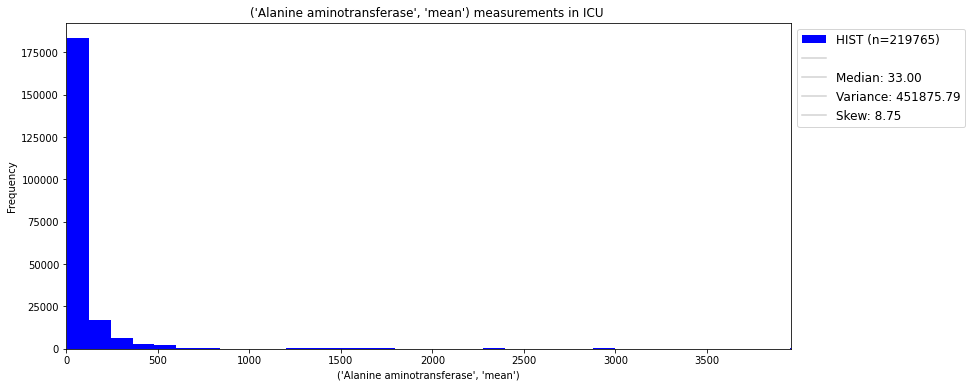

<Figure size 936x432 with 0 Axes>

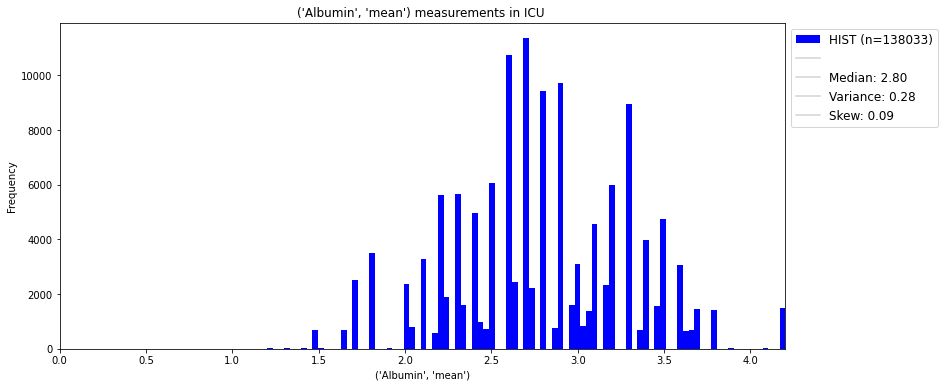

<Figure size 936x432 with 0 Axes>

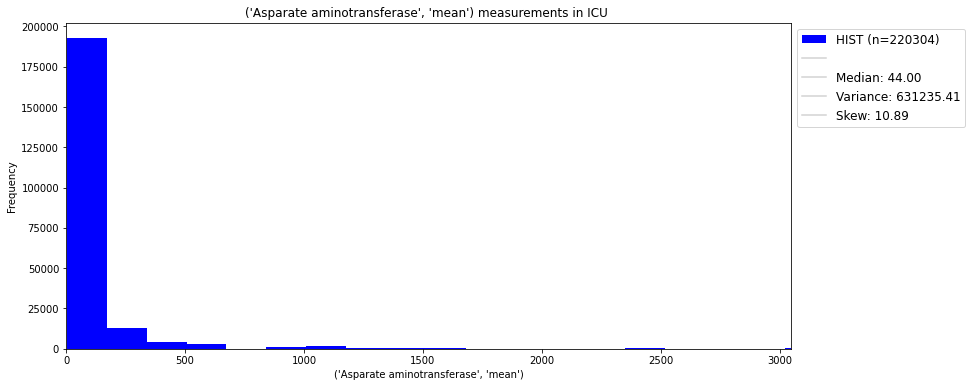

<Figure size 936x432 with 0 Axes>

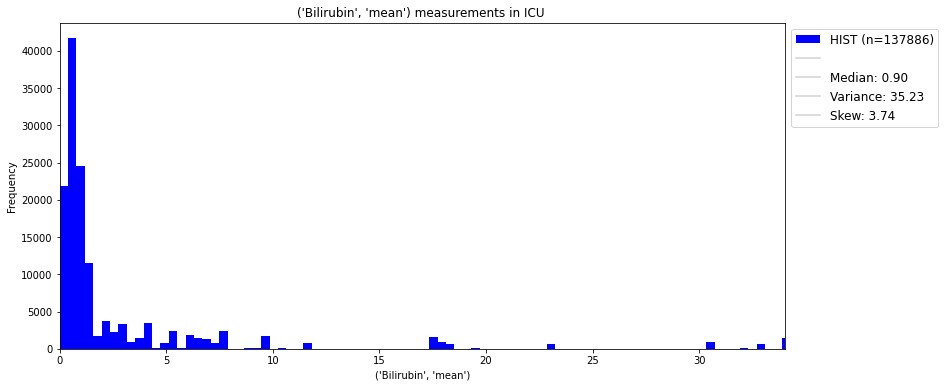

<Figure size 936x432 with 0 Axes>

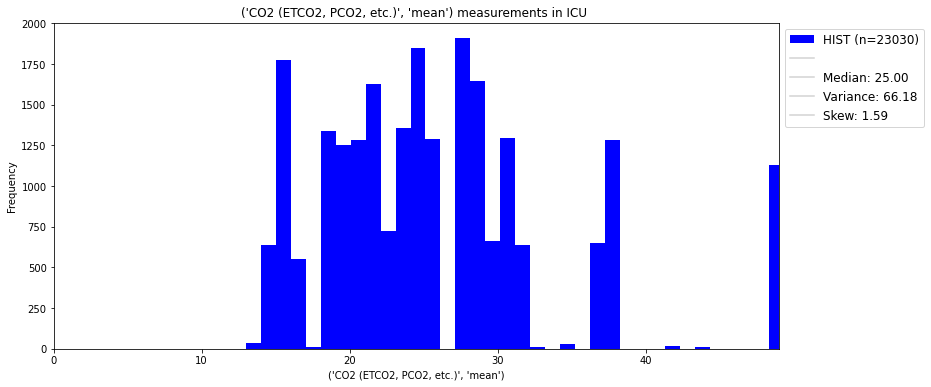

<Figure size 936x432 with 0 Axes>

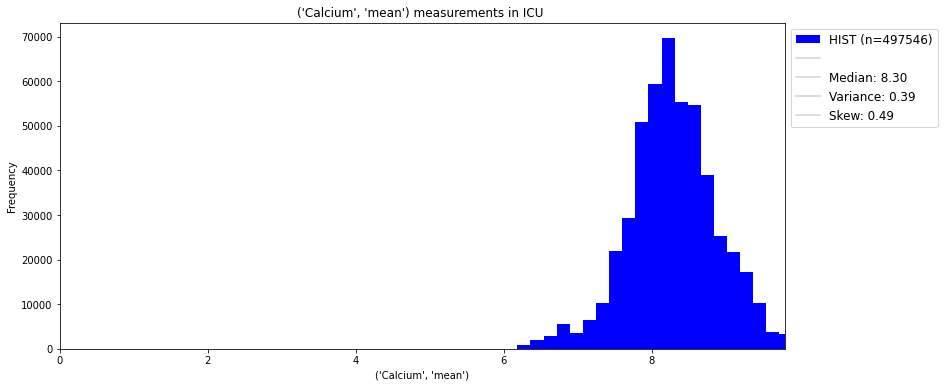

<Figure size 936x432 with 0 Axes>

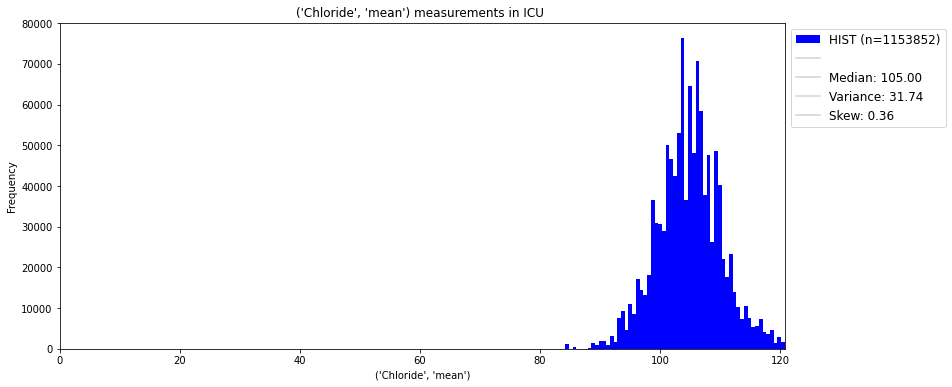

<Figure size 936x432 with 0 Axes>

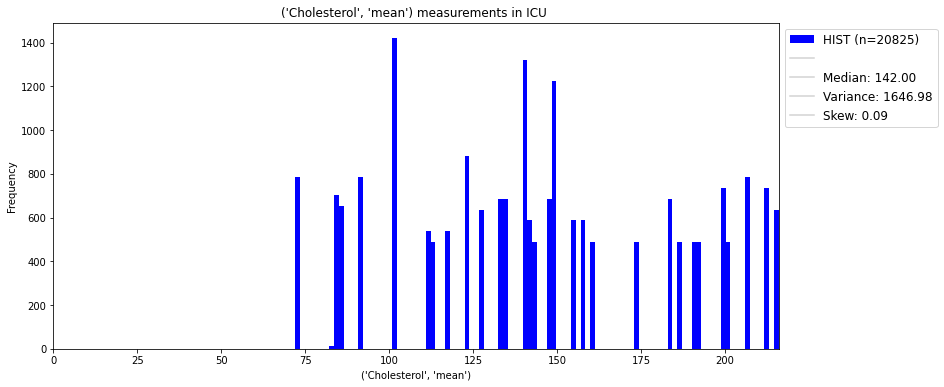

<Figure size 936x432 with 0 Axes>

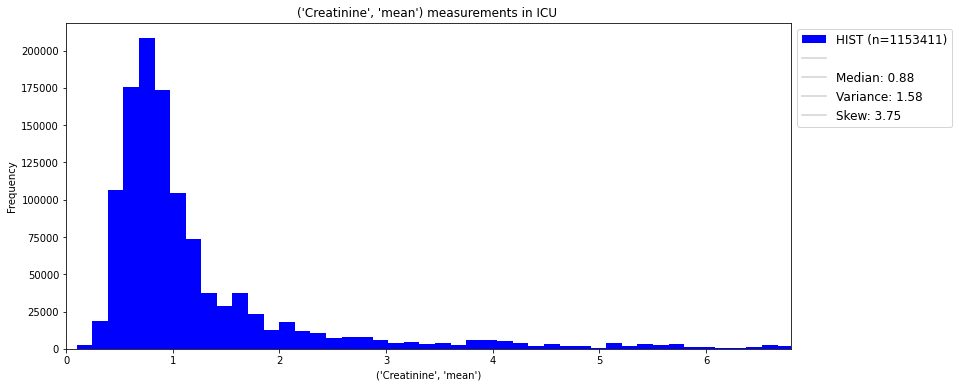

<Figure size 936x432 with 0 Axes>

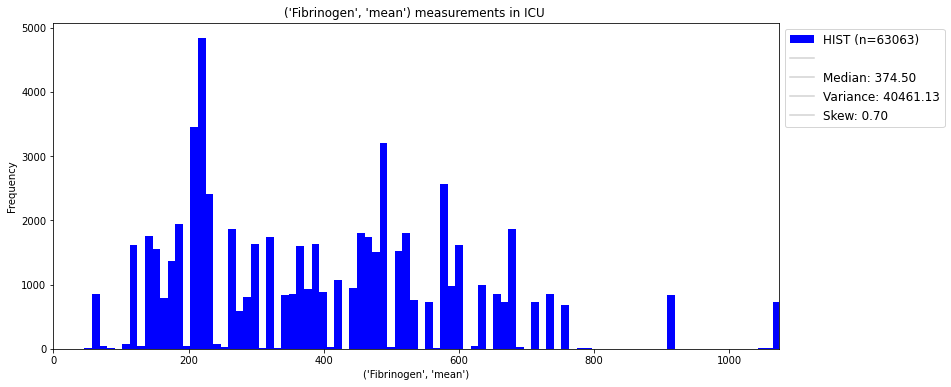

<Figure size 936x432 with 0 Axes>

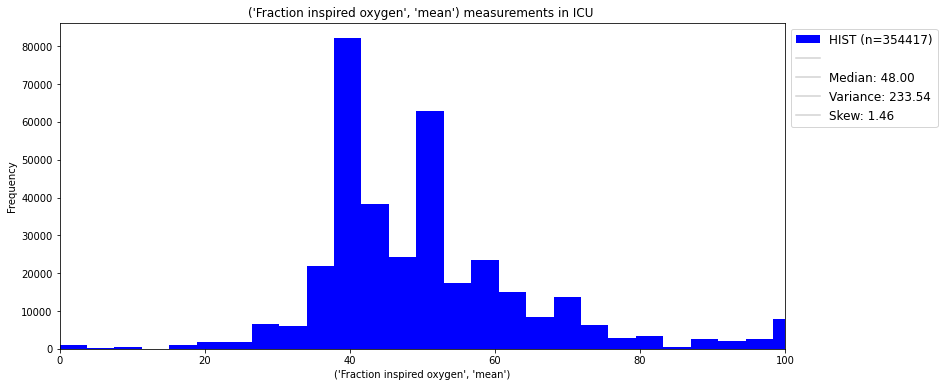

<Figure size 936x432 with 0 Axes>

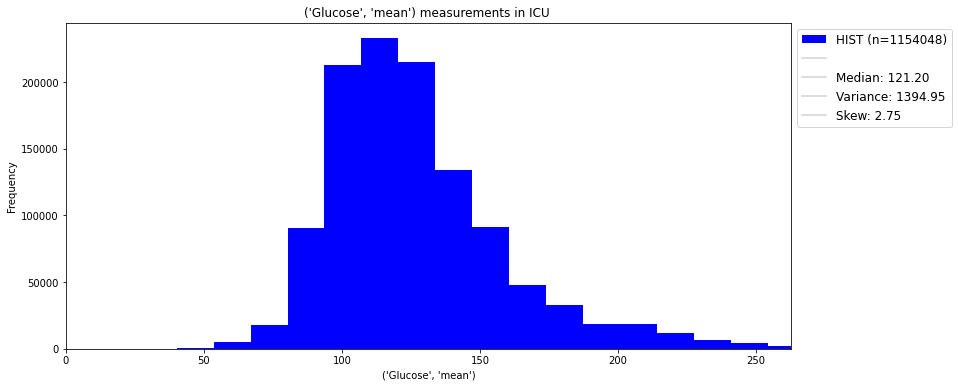

<Figure size 936x432 with 0 Axes>

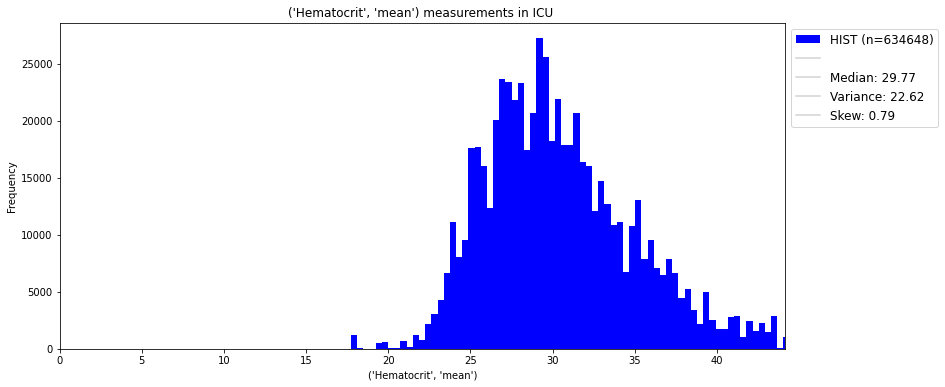

<Figure size 936x432 with 0 Axes>

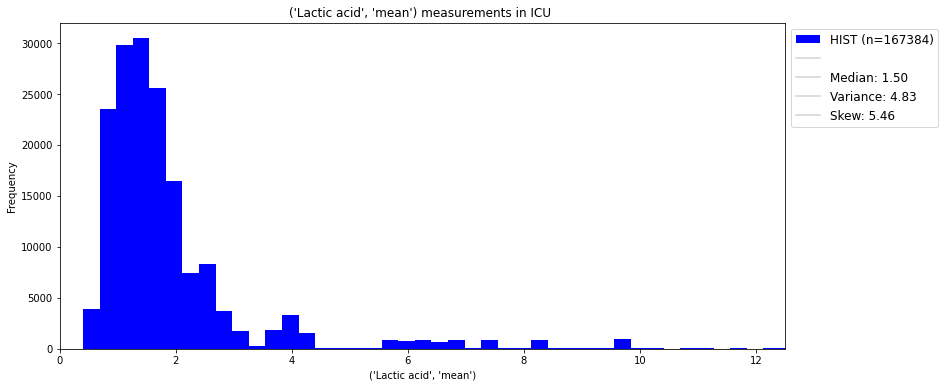

<Figure size 936x432 with 0 Axes>

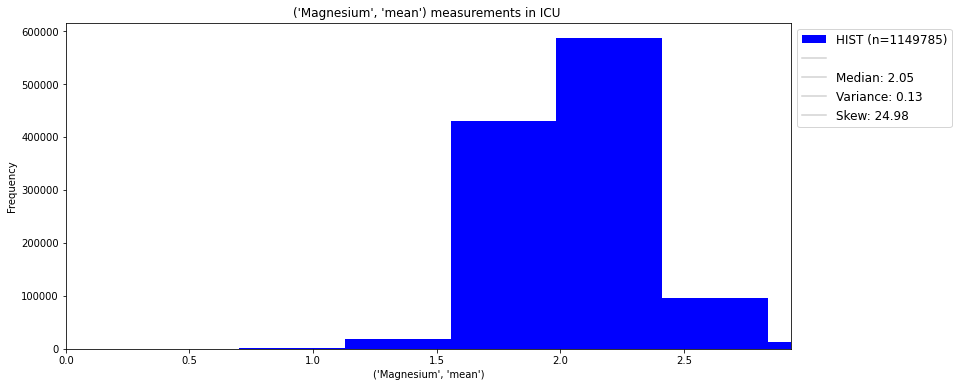

<Figure size 936x432 with 0 Axes>

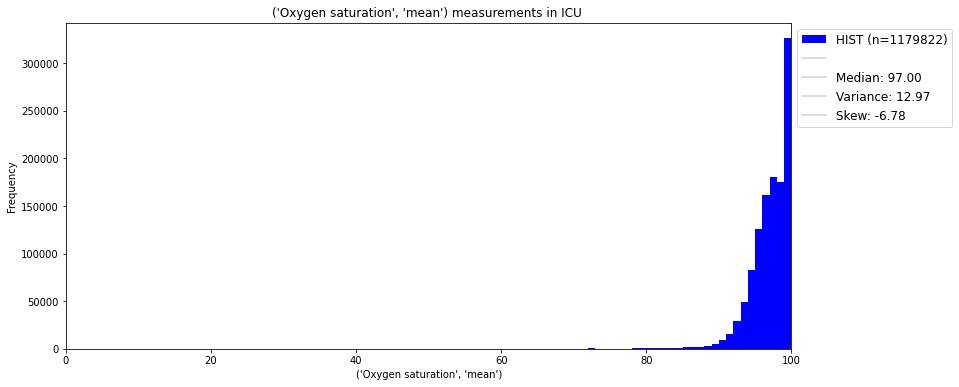

<Figure size 936x432 with 0 Axes>

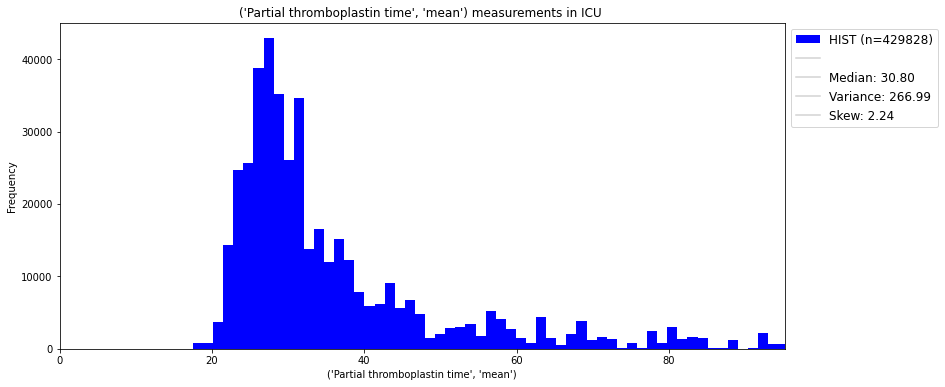

<Figure size 936x432 with 0 Axes>

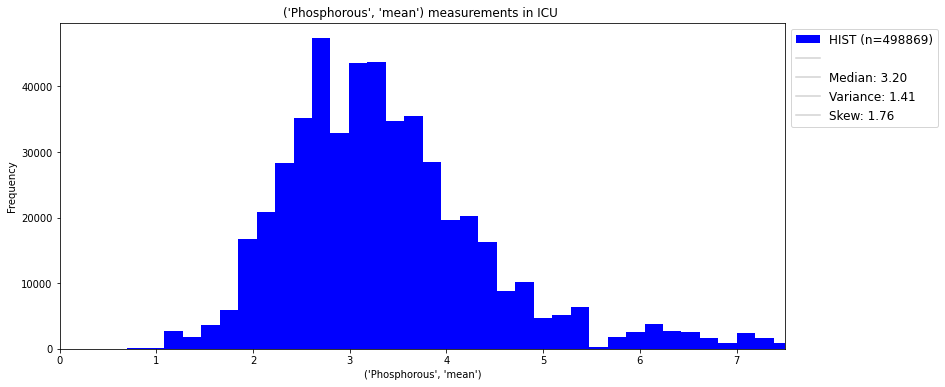

<Figure size 936x432 with 0 Axes>

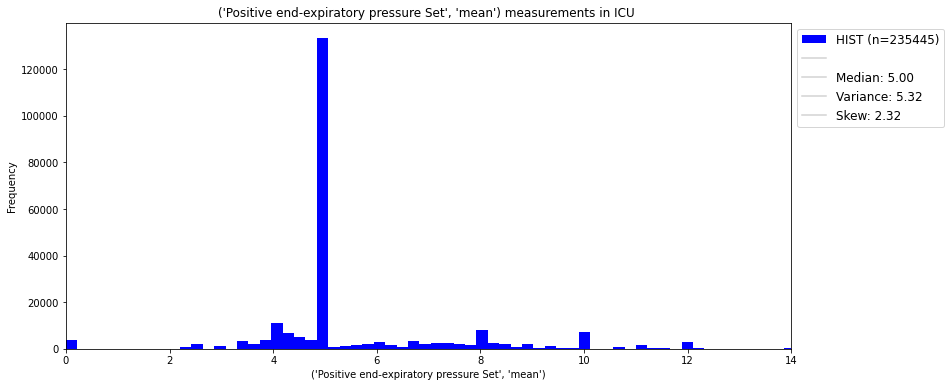

<Figure size 936x432 with 0 Axes>

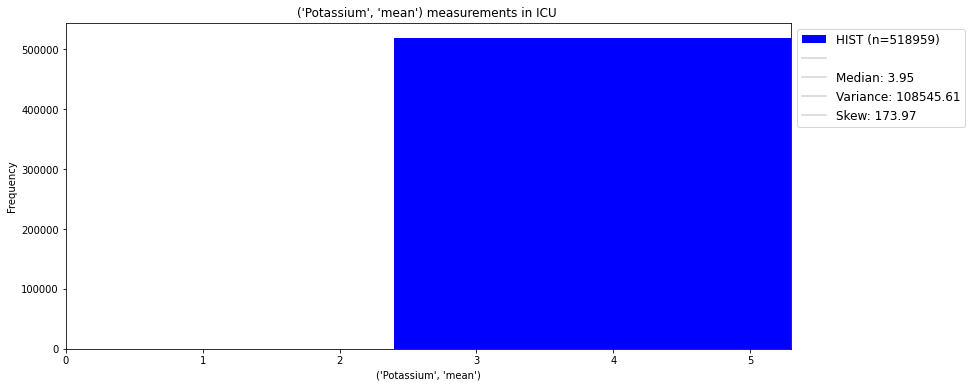

<Figure size 936x432 with 0 Axes>

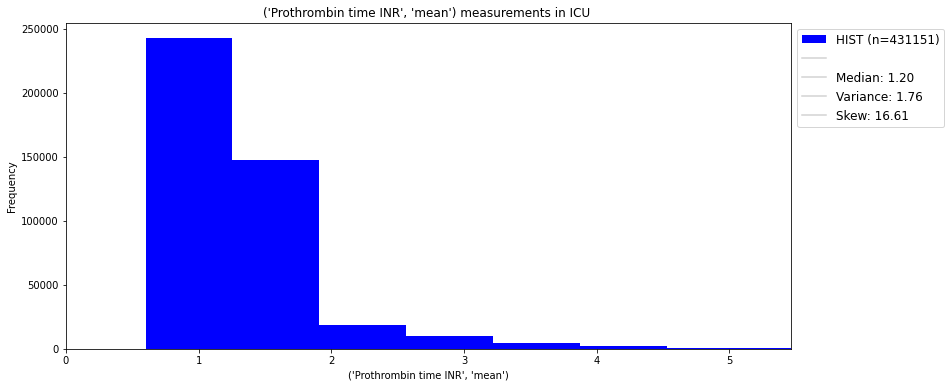

<Figure size 936x432 with 0 Axes>

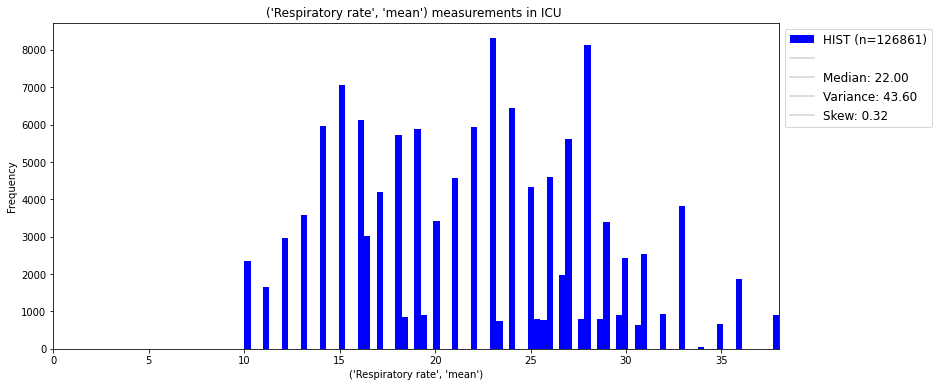

<Figure size 936x432 with 0 Axes>

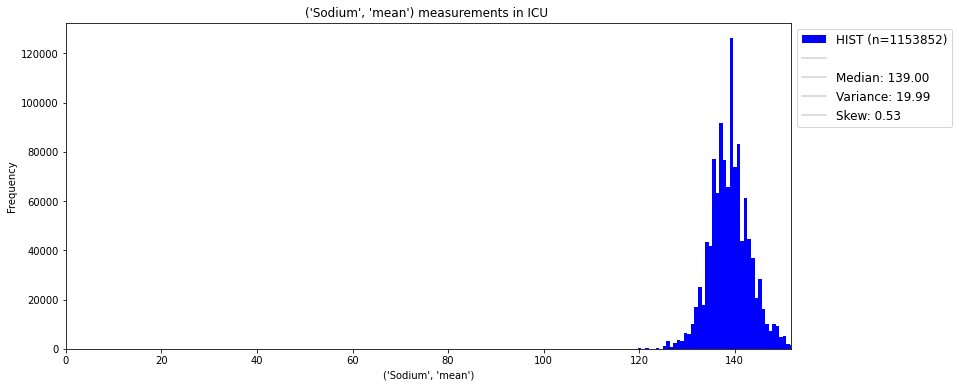

<Figure size 936x432 with 0 Axes>

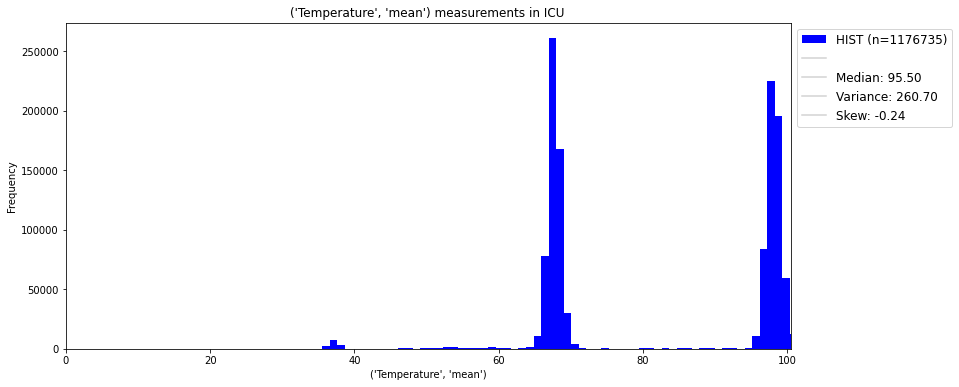

<Figure size 936x432 with 0 Axes>

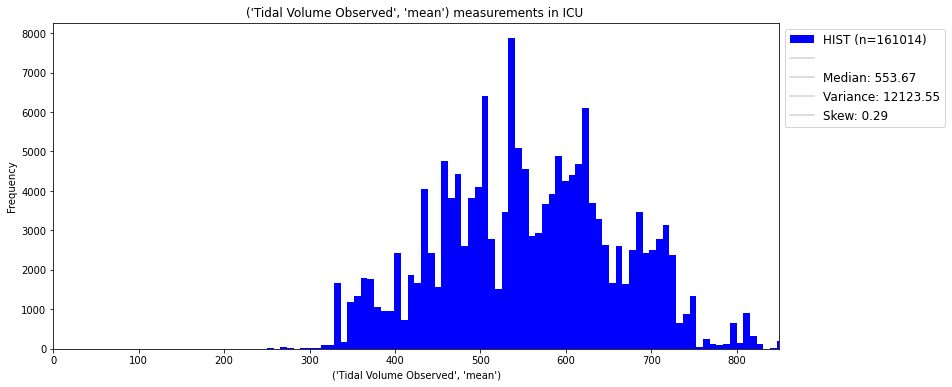

<Figure size 936x432 with 0 Axes>

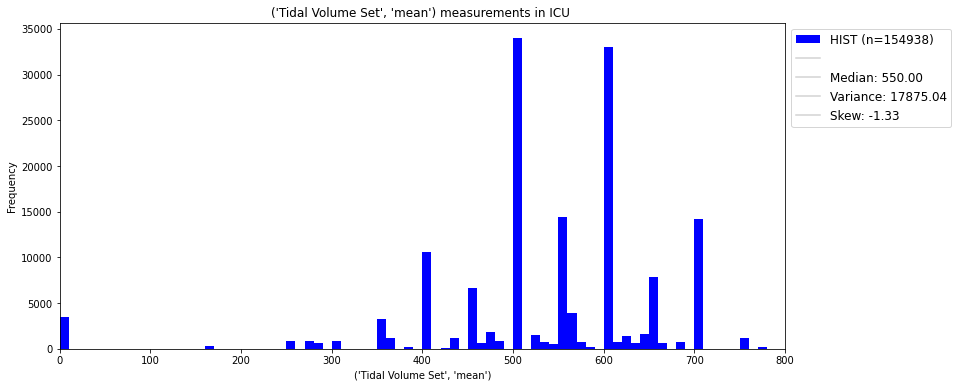

<Figure size 936x432 with 0 Axes>

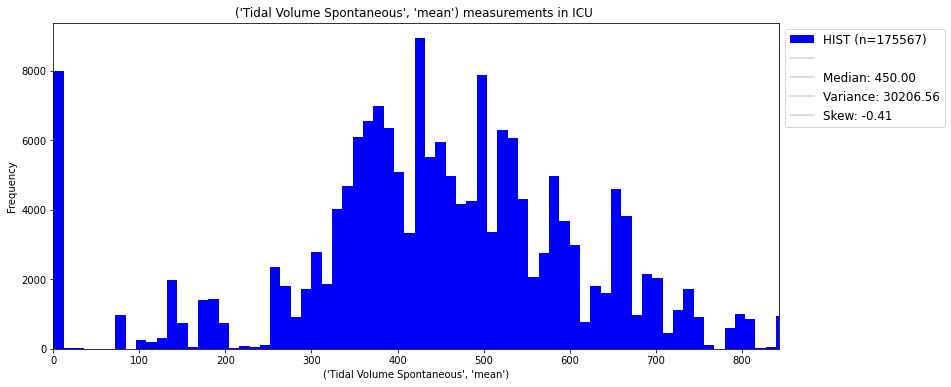

<Figure size 936x432 with 0 Axes>

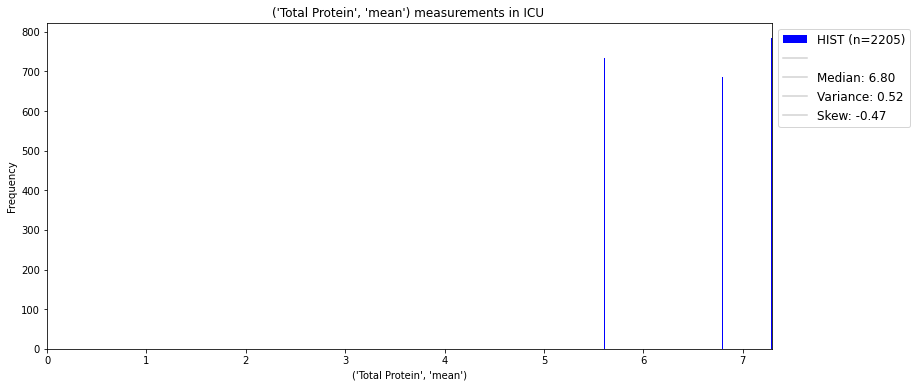

<Figure size 936x432 with 0 Axes>

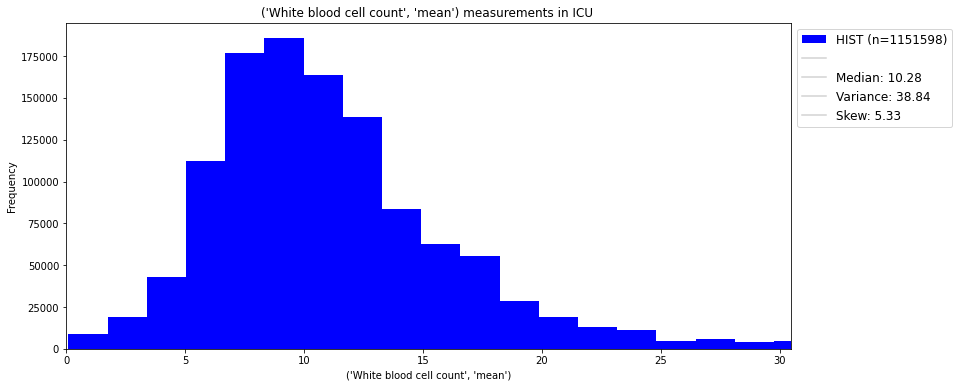

<Figure size 936x432 with 0 Axes>

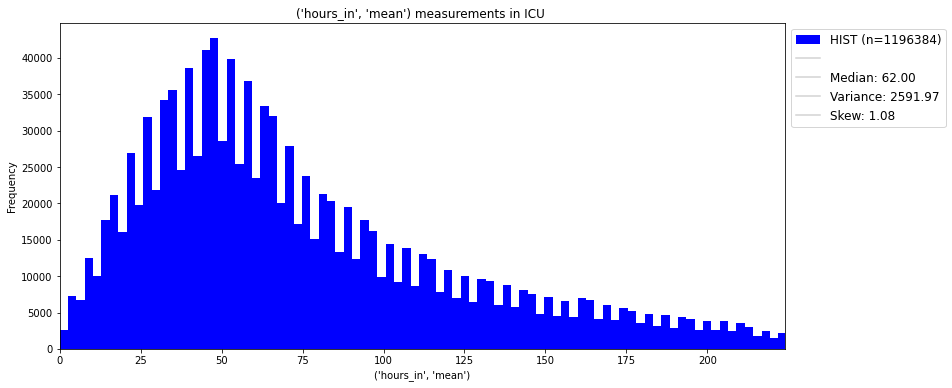

<Figure size 936x432 with 0 Axes>

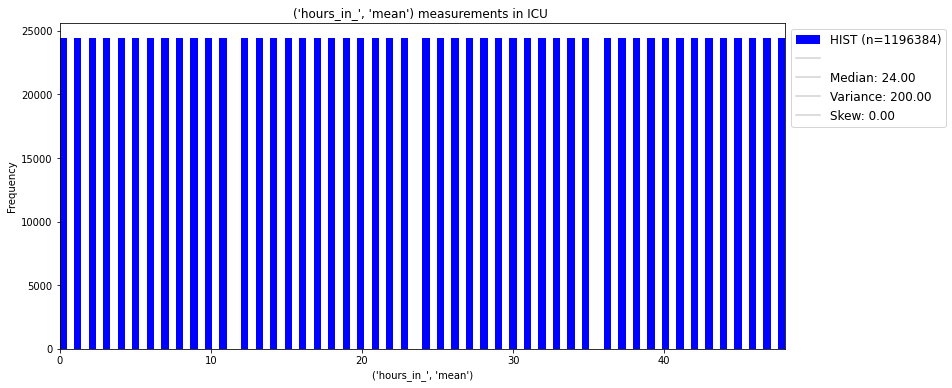

<Figure size 936x432 with 0 Axes>

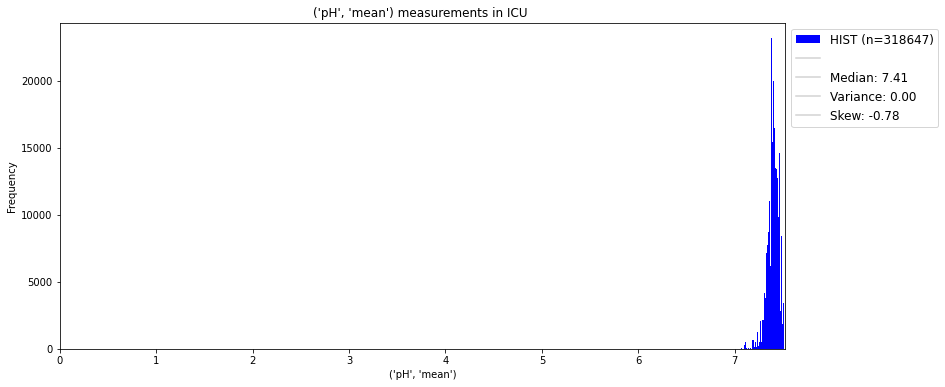

In [124]:
neg = demographics[demographics['mort_icu'] == 0].subject_id
pos = demographics[demographics['mort_icu'] == 1].subject_id
def plot_variable_histograms(col_names, df):
    # Plot some of the data, just to make sure it looks ok
    for c, vals in df.iteritems():
        n = vals.dropna().count()
        #m = vals.index.values
        m = list(set(list(list(zip(*vals.index.values))[0])))

        """
        
        if any(x in m for x in pos):
            color = 'blue'
            print(color)
        elif any(x in m for x in neg): 
            color = 'red'
            print(color)
        """
        if n < 2: continue

        # get median, variance, skewness
        med = vals.dropna().median()
        var = vals.dropna().var()
        skew = vals.dropna().skew()

        # plot
        fig = plt.figure(figsize=(13, 6))
        plt.subplots(figsize=(13,6))
        vals.dropna().plot.hist(bins=100, label='HIST (n={})'.format(n), color = 'blue')

        # fake plots for KS test, median, etc
        plt.plot([], label=' ',color='lightgray')
        plt.plot([], label='Median: {}'.format(format(med,'.2f')),
                 color='lightgray')
        plt.plot([], label='Variance: {}'.format(format(var,'.2f')),
                 color='lightgray')
        plt.plot([], label='Skew: {}'.format(format(skew,'.2f')),
                 color='lightgray')

        # add title, labels etc.
        plt.title('{} measurements in ICU '.format(str(c)))
        plt.xlabel(str(c))
        plt.legend(loc="upper left", bbox_to_anchor=(1,1),fontsize=12)
        plt.xlim(0, vals.quantile(0.99))
        #fig.savefig(os.path.join(outPath, (str(c) + '_HIST_.png')), bbox_inches='tight')

plot_variable_histograms(vital_labs_48_imp.columns, vital_labs_48_imp)

## Vasopressors 

In [ ]:
vaso_mv = pd.read_hdf('data_icu.h5', key='vaso_mv') 
vaso_cv = pd.read_hdf('data_icu.h5', key='vaso_cv') 

#### hourly buckets ####################################
to_hours = lambda x: max(0, x.days*24 + x.seconds // 3600)


# add the remaining patients that did not have vasopressors with label in has_vasopressors = 0 
demographics.reset_index(inplace=True)
patients_missing_vaso = demographics[~demographics.subject_id.isin(vaso_cv.subject_id)][['subject_id', 'hadm_id', 'icustay_id']]
patients_missing_vaso.head()


vaso_cv_wip = vaso_cv.sort_values(["subject_id", "charttime"])

# vaso_cv_wip['has_vasopressors'] = vaso_cv_wip['has_vasopressors'].fillna(0)


demographics = demographics.set_index('icustay_id')
vaso_cv_wip = vaso_cv_wip.set_index('icustay_id').join(demographics[['intime', 'outtime']])
vaso_cv_wip['hours_in'] = (vaso_cv_wip['charttime'] - vaso_cv_wip['intime']).apply(to_hours)

vaso_cv_wip = vaso_cv_wip.sort_values(["subject_id", "charttime"])
vaso_cv_wip = vaso_cv_wip.reset_index()


vaso_cv_wip.drop(['rate', 'has_vasopressors', 'amount'], axis=1, inplace=True)
vaso_cv_wip.set_index('subject_id', inplace=True)
vaso_cv_wip.reset_index(inplace=True)

# does it make sense to take the mean of a rate?
vaso_cv_wip = vaso_cv_wip.groupby(['subject_id', 'hadm_id', 'icustay_id'] +  ['itemid'] + ['hours_in']).agg(['mean', 'std', 'count'])


vaso_cv_wip.columns = vaso_cv_wip.columns.droplevel(0)
vaso_cv_wip.columns.names = ['Aggregated']
"""

vaso_cv_wip = vaso_cv_wip.unstack(level = ['itemid'])
vaso_cv_wip.columns = vaso_cv_wip.columns.reorder_levels(order=['itemid'] + ['Aggregated'])
vaso_cv_wip = vaso_cv_wip.sort_index(axis=0).sort_index(axis=1)
"""


vaso_cv_wip

In [ ]:
vaso_cv_wip = vaso_cv_wip.unstack(level = ['itemid'])
#vaso_cv_wip = vaso_cv_wip.drop_duplicates('itemid')
#vaso_cv_wip.unstack(level = ['itemid'])

In [ ]:
vaso_cv_wip


In [ ]:
print_proportions(vaso_cv_wip)

In [ ]:
vaso_mv = pd.read_hdf('data_icu.h5', key='vaso_mv') 
#vaso_cv = pd.read_hdf('data_icu.h5', key='vaso_cv') 

#### hourly buckets ####################################
to_hours = lambda x: max(0, x.days*24 + x.seconds // 3600)


# add the remaining patients that did not have vasopressors with label in has_vasopressors = 0 
demographics.reset_index(inplace=True)
patients_missing_vaso_mv = demographics[~demographics.subject_id.isin(vaso_mv.subject_id)][['subject_id', 'hadm_id', 'icustay_id']]
patients_missing_vaso_mv.head()


vaso_mv_wip = vaso_mv.sort_values(["subject_id", "starttime"])

# vaso_cv_wip['has_vasopressors'] = vaso_cv_wip['has_vasopressors'].fillna(0)


demographics = demographics.set_index('icustay_id')
vaso_mv_wip = vaso_mv_wip.set_index('icustay_id').join(demographics[['intime', 'outtime']])
vaso_mv_wip['hours_in'] = (vaso_mv_wip['starttime'] - vaso_mv_wip['intime']).apply(to_hours)

vaso_mv_wip = vaso_mv_wip.sort_values(["subject_id", "starttime"])
vaso_mv_wip = vaso_mv_wip.reset_index()


vaso_mv_wip.drop(['amount', 'has_vasopressors'], axis=1, inplace=True)
vaso_mv_wip.set_index('subject_id', inplace=True)
vaso_mv_wip.reset_index(inplace=True)

# does it make sense to take the mean of a rate?
vaso_mv_wip = vaso_mv_wip.groupby(['subject_id', 'hadm_id', 'icustay_id'] +  ['itemid'] + ['hours_in']).agg(['mean', 'std', 'count'])


vaso_mv_wip.columns = vaso_mv_wip.columns.droplevel(0)
vaso_mv_wip.columns.names = ['Aggregated']
vaso_mv_wip = vaso_mv_wip.unstack(level = ['itemid'])
vaso_mv_wip.columns = vaso_mv_wip.columns.reorder_levels(order=['itemid'] + ['Aggregated'])
vaso_mv_wip = vaso_mv_wip.sort_index(axis=0).sort_index(axis=1)
vaso_mv_wip

In [ ]:
print_proportions(vaso_mv_wip)

## Mechanical Ventilation

In [125]:
mech_vent = pd.read_hdf('data_icu.h5', key='mech_vent') 

mech_vent.head()

,subject_id,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated
0,3,145834,211552,2101-10-20 19:15:00,0,0,0,0
1,3,145834,211552,2101-10-20 20:00:00,1,0,0,0
2,3,145834,211552,2101-10-20 21:15:00,0,0,0,0
3,3,145834,211552,2101-10-20 23:15:00,1,0,0,0
4,3,145834,211552,2101-10-21 04:15:00,1,0,0,0


In [126]:
# add the remaining patients that did not have vasopressors with label in has_vasopressors = 0 
demographics.reset_index(inplace=True)
patients_missing_mech_vent = demographics[~demographics.subject_id.isin(mech_vent.subject_id)][['subject_id', 'hadm_id', 'icustay_id']]
patients_missing_mech_vent.head()

,subject_id,hadm_id,icustay_id
42,67,186474,286338
122,181,102631,246694
155,235,117941,236962
171,256,155415,295852
187,276,135156,206327


In [127]:
print("patiens that did not receive mechanical ventil", len(set(patients_missing_mech_vent.subject_id)))
print("patiens that did not receive mechanical ventil", len(set(mech_vent.subject_id)))

patiens that did not receive mechanical ventil 713
patiens that did not receive mechanical ventil 33938


In [128]:
mech_vent

,subject_id,hadm_id,icustay_id,charttime,mechvent,oxygentherapy,extubated,selfextubated
0,3,145834,211552,2101-10-20 19:15:00,0,0,0,0
1,3,145834,211552,2101-10-20 20:00:00,1,0,0,0
2,3,145834,211552,2101-10-20 21:15:00,0,0,0,0
3,3,145834,211552,2101-10-20 23:15:00,1,0,0,0
4,3,145834,211552,2101-10-21 04:15:00,1,0,0,0
...,...,...,...,...,...,...,...,...
695912,99999,113369,246512,2117-12-31 16:00:00,0,1,0,0
695913,99999,113369,246512,2117-12-31 20:00:00,0,0,0,0
695914,99999,113369,246512,2117-12-31 22:00:00,0,0,0,0
695915,99999,113369,246512,2118-01-01 00:00:00,0,0,0,0


In [129]:
def print_proportions(df):
    """
    # Print the total proportions!

    input: pandas df
    
    """


    rows, vars = df.shape
    print('')
    for l, vals in df.iteritems():

        ratio = 1.0 * vals.count() / rows
        print(str(l) + ': ' + str(round(ratio, 3)*100) + '% present')

    return None 


In [130]:
#### hourly buckets ####################################
to_hours = lambda x: max(0, x.days*24 + x.seconds // 3600)


mech_vent_wip = mech_vent.sort_values(["subject_id", "charttime"])
#vaso_cv_wip.reset_index(drop=True)
mech_vent_wip.head()


demographics = demographics.reset_index()
demographics = demographics.set_index('icustay_id')
mech_vent_wip = mech_vent_wip.set_index('icustay_id').join(demographics[['intime', 'outtime']])
mech_vent_wip['hours_in'] = (mech_vent_wip['charttime'] - mech_vent_wip['intime']).apply(to_hours)
mech_vent_wip = mech_vent_wip.sort_values(["subject_id", "charttime"])
mech_vent_wip = mech_vent_wip.reset_index()

mech_vent_wip.drop(['intime', 'outtime'], axis=1, inplace=True)
mech_vent_wip.set_index('subject_id', inplace=True)
#
mech_vent_wip.reset_index(inplace=True)
mech_vent_wip = mech_vent_wip.groupby(['subject_id', 'hadm_id', 'icustay_id']  + ['hours_in']).agg(['min', 'count'])
mech_vent_wip

charttime       mechvent  \
                                                       min count      min   
subject_id hadm_id icustay_id hours_in                                      
3          145834  211552     0        2101-10-20 19:15:00     2        0   
                              2        2101-10-20 21:15:00     1        0   
                              4        2101-10-20 23:15:00     1        1   
                              9        2101-10-21 04:15:00     1        1   
                              11       2101-10-21 07:00:00     1        1   
...                                                    ...   ...      ...   
99999      113369  246512     4        2117-12-31 16:00:00     1        0   
                              8        2117-12-31 20:00:00     1        0   
                              10       2117-12-31 22:00:00     1        0   
                              12       2118-01-01 00:00:00     1        0   
                              14       2118-01-01 02:00:00     1        0   

                                             oxygentherapy       extubated  \
                                       count           min count       min   
subject_id hadm_id icustay_id hours_in                                       
3          145834  211552     0            2             0     2         0   
                              2            1             0     1         0   
                              4            1             0     1         0   
                              9            1             0     1         0   
                              11           1             0     1         0   
...                                      ...           ...   ...       ...   
99999      113369  246512     4            1             1     1         0   
                              8            1             0     1         0   
                              10           1             0     1         0   
                              12           1             0     1         0   
                              14           1             0     1         0   

                                             selfextubated        
                                       count           min count  
subject_id hadm_id icustay_id hours_in                            
3          145834  211552     0            2             0     2  
                              2            1             0     1  
                              4            1             0     1  
                              9            1             0     1  
                              11           1             0     1  
...                                      ...           ...   ...  
99999      113369  246512     4            1             0     1  
                              8            1             0     1  
                              10           1             0     1  
                              12           1             0     1  
                              14           1             0     1  

[626748 rows x 10 columns]

In [133]:
print("patiens that did not receive mechanical ventil", len(set(mech_vent_wip.mechvent)))

patiens that did not receive mechanical ventil 2


In [134]:
mech_vent_wip_reset = mech_vent_wip.reset_index(level=3)
df_to_keep = []
for i in set(mech_vent_wip_reset.index):
    #print(labs_vitals_red_reset.loc[[i[0]]][-48:])
    if len(mech_vent_wip_reset.loc[[i[0]]].hours_in)>=49:
        df_to_keep.append(mech_vent_wip_reset.loc[[i[0]]][-49:])
mech_vent_48 = pd.concat(df_to_keep)
#hours_in = len(set(mech_vent_48.index)) * list(range(49))
#mech_vent_48['hours_in_'] = hours_in


ValueError: Length of values (112014) does not match length of index (112112)

In [135]:
mech_vent_48

hours_in           charttime       mechvent  \
                                                       min count      min   
subject_id hadm_id icustay_id                                               
43099      179031  272630           34 2169-11-12 16:00:00     1        1   
                   272630           38 2169-11-12 20:00:00     1        1   
                   272630           42 2169-11-13 00:00:00     1        1   
                   272630           46 2169-11-13 04:00:00     1        1   
                   272630           50 2169-11-13 08:00:00     1        1   
...                                ...                 ...   ...      ...   
43412      182019  258741          186 2169-07-07 20:00:00     1        0   
                   258741          187 2169-07-07 21:00:00     1        0   
                   258741          190 2169-07-08 00:00:00     1        0   
                   258741          194 2169-07-08 04:00:00     1        0   
                   258741          195 2169-07-08 05:00:00     1        0   

                                    oxygentherapy       extubated        \
                              count           min count       min count   
subject_id hadm_id icustay_id                                             
43099      179031  272630         1             0     1         0     1   
                   272630         1             0     1         0     1   
                   272630         1             0     1         0     1   
                   272630         1             0     1         0     1   
                   272630         1             0     1         0     1   
...                             ...           ...   ...       ...   ...   
43412      182019  258741         1             1     1         0     1   
                   258741         1             1     1         0     1   
                   258741         1             1     1         0     1   
                   258741         1             1     1         0     1   
                   258741         1             1     1         0     1   

                              selfextubated        
                                        min count  
subject_id hadm_id icustay_id                      
43099      179031  272630                 0     1  
                   272630                 0     1  
                   272630                 0     1  
                   272630                 0     1  
                   272630                 0     1  
...                                     ...   ...  
43412      182019  258741                 0     1  
                   258741                 0     1  
                   258741                 0     1  
                   258741                 0     1  
                   258741                 0     1  

[112112 rows x 11 columns]

## Crystalloid and colloid bolus fluids

In [136]:
# here we have listed the amount of a drug or 
# substance administered to the patient either between 
# the STARTTIME and ENDTIME (if both are available) or at the ENDTIME 
# in milliliteres 
colloid_bolus = pd.read_hdf('data_icu.h5', key='colloid_bolus') 
crystalloid_bolus = pd.read_hdf('data_icu.h5', key='crystalloid_bolus')

In [137]:
# colloid bolus
demographics.reset_index(inplace=True)
patients_missing_colloid_bolus = demographics[~demographics.subject_id.isin(colloid_bolus.subject_id)][['subject_id', 'hadm_id', 'icustay_id']]

colloid_bolus_wip = colloid_bolus.sort_values(["subject_id", "charttime"])

demographics = demographics.set_index('icustay_id')
colloid_bolus_wip = colloid_bolus_wip.set_index('icustay_id').join(demographics[['intime', 'outtime']])
colloid_bolus_wip['hours_in'] = (colloid_bolus_wip['charttime'] - colloid_bolus_wip['intime']).apply(to_hours)
colloid_bolus_wip = colloid_bolus_wip.sort_values(["subject_id", "charttime"])
colloid_bolus_wip = colloid_bolus_wip.reset_index()

colloid_bolus_wip.drop(['intime', 'outtime'], axis=1, inplace=True)
colloid_bolus_wip.set_index('subject_id', inplace=True)
#
colloid_bolus_wip.reset_index(inplace=True)
# does it make sense to take the mean of a rate?
colloid_bolus_wip = colloid_bolus_wip.groupby(['subject_id', 'hadm_id', 'icustay_id']  + ['hours_in']).agg(['mean', 'std', 'count'])
colloid_bolus_wip.head()



colloid_bolus          
                                                 mean std count
subject_id hadm_id  icustay_id hours_in                        
20         157681.0 264490     8                500.0 NaN     1
114        178393.0 258626     11               500.0 NaN     1
                               18               500.0 NaN     1
115        114585.0 232514     2                500.0 NaN     1
                               8                500.0 NaN     1

In [138]:
print_proportions(colloid_bolus_wip)


('colloid_bolus', 'mean'): 100.0% present
('colloid_bolus', 'std'): 3.0% present
('colloid_bolus', 'count'): 100.0% present


In [139]:
#crystalloid bolus
demographics.reset_index(inplace=True)
patients_missing_crystalloid_bolus = demographics[~demographics.subject_id.isin(crystalloid_bolus.subject_id)][['subject_id', 'hadm_id', 'icustay_id']]

crystalloid_bolus_wip = crystalloid_bolus.sort_values(["subject_id", "charttime"])

demographics = demographics.set_index('icustay_id')
crystalloid_bolus_wip = crystalloid_bolus_wip.set_index('icustay_id').join(demographics[['intime', 'outtime']])
crystalloid_bolus_wip['hours_in'] = (crystalloid_bolus_wip['charttime'] - crystalloid_bolus_wip['intime']).apply(to_hours)
crystalloid_bolus_wip = crystalloid_bolus_wip.sort_values(["subject_id", "charttime"])
crystalloid_bolus_wip = crystalloid_bolus_wip.reset_index()

crystalloid_bolus_wip.drop(['intime', 'outtime'], axis=1, inplace=True)
crystalloid_bolus_wip.set_index('subject_id', inplace=True)
#
crystalloid_bolus_wip.reset_index(inplace=True)
# does it make sense to take the mean of a rate?
crystalloid_bolus_wip = crystalloid_bolus_wip.groupby(['subject_id', 'hadm_id', 'icustay_id']  + ['hours_in']).agg(['mean', 'std', 'count'])
crystalloid_bolus_wip.head()

crystalloid_bolus          
                                                     mean std count
subject_id hadm_id  icustay_id hours_in                            
3          145834.0 211552     15                   500.0 NaN     1
                               18                   820.0 NaN     1
                               22                   500.0 NaN     1
                               24                   500.0 NaN     1
                               27                   500.0 NaN     1

In [140]:
print_proportions(crystalloid_bolus_wip)


('crystalloid_bolus', 'mean'): 100.0% present
('crystalloid_bolus', 'std'): 5.8999999999999995% present
('crystalloid_bolus', 'count'): 100.0% present


## Antiobiotics

In [ ]:
antibiotics = pd.read_hdf('data_icu.h5', key='antibiotics')

antibiotics.head()

In [ ]:

demographics.reset_index(inplace=True)
patients_missing_antibiotics = demographics[~demographics.subject_id.isin(antibiotics.subject_id)][['subject_id', 'hadm_id', 'icustay_id']]

antibiotics_wip = antibiotics.sort_values(["subject_id", "startdate"])

demographics = demographics.set_index('icustay_id')
antibiotics_wip = antibiotics_wip.set_index('icustay_id').join(demographics[['intime', 'outtime']])
antibiotics_wip['hours_in'] = (antibiotics_wip['startdate'] - antibiotics_wip['intime']).apply(to_hours)
antibiotics_wip = antibiotics_wip.sort_values(["subject_id", "startdate"])
antibiotics_wip = antibiotics_wip.reset_index()

antibiotics_wip.drop(['intime', 'outtime', 'startdate', 'enddate', 'drug_name_generic', 'route'], axis=1, inplace=True)
antibiotics_wip.set_index('subject_id', inplace=True)
#
antibiotics_wip.reset_index(inplace=True)
# does it make sense to take the mean of a rate?
antibiotics_wip = antibiotics_wip.groupby(['subject_id', 'hadm_id', 'icustay_id']  + ['drug'] + ['hours_in']).agg(['count'])
antibiotics_wip.columns = antibiotics_wip.columns.droplevel(0)

antibiotics_wip.columns.names = ['Aggregated']

antibiotics_wip = antibiotics_wip.unstack(level = ['drug'])
antibiotics_wip.columns = antibiotics_wip.columns.reorder_levels(order=['drug'] + ['Aggregated'])
   
#X = X.reindex(fill_df.index)


antibiotics_wip = antibiotics_wip.sort_index(axis=0).sort_index(axis=1)
antibiotics_wip.head()

In [ ]:
#drop columns with few recordings

antibiotics_wip_red = drop_recordings(antibiotics_wip, 'mean', 0.99)
antibiotics_wip_red

In [ ]:
print_proportions(antibiotics_wip_red)

## Diagnoses

In [ ]:
diagnoses = pd.read_hdf('data_icu.h5', key='diagnoses') 
diagnoses.head()

In [ ]:
diagnoses_wip = diagnoses.groupby(['subject_id', 'hadm_id']  + ['icd9_title']).agg(['count'])
diagnoses_wip

In [ ]:
diagnoses_wip.columns = diagnoses_wip.columns.droplevel(0)

diagnoses_wip.columns.names = ['Aggregated']

diagnoses_wip = diagnoses_wip.unstack(level = ['icd9_title'])
diagnoses_wip.columns = diagnoses_wip.columns.reorder_levels(order=['icd9_title'] + ['Aggregated'])
   
diagnoses_wip = diagnoses_wip.sort_index(axis=0).sort_index(axis=1)
diagnoses_wip

In [ ]:
print_proportions(diagnoses_wip)

## Analysis and Plotting

In [ ]:
print("Number of patients hospitalized: ", len(set((demographics.subject_id))))
print("Number of patients with in hospital mortality: ", demographics.mort_hosp.value_counts())
print("Number of patients with in icu mortality: ", demographics.mort_icu.value_counts())